#Kütüphanelerin Yüklenmesi ve Giriş Görüntüsünün Okunması

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("yeni.jpg", "https://images.unsplash.com/photo-1570310052400-89ff7a2adb20?q=80&w=1470&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
result_prefix = "yeni_dream"

#Bunlar aktivasyonu en üst düzeye çıkarmaya çalıştığımız katmanların adları
#ve en üst düzeye çıkarmaya çalıştığımız son kayıptaki ağırlıklarıdır.

#Yeni görsel efektler elde etmek için bu ayarı düzenleyebilirsiniz.
layer_settings = {
    "mixed4":2.0,
    "mixed5":3.5,
    "mixed6":2.0,
    "mixed7":3.5,
    }

#Bu hiperparametrelerle oynamak da yeni efektler elde etmenizi sağlar.
step = 0.01 #Gradyan çıkış adımı boyutu
num_octave = 3 #Gradyan yükselmesinin çalıştıracağı ölçek sayısı
octave_scale = 1.4 #Ölçekler arasındaki boyut oranı
iterations = 20 #Ölçek başına çıkış adımı sayısı
max_loss = 15.0

226983/226983 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###Giriş Görüntüsü

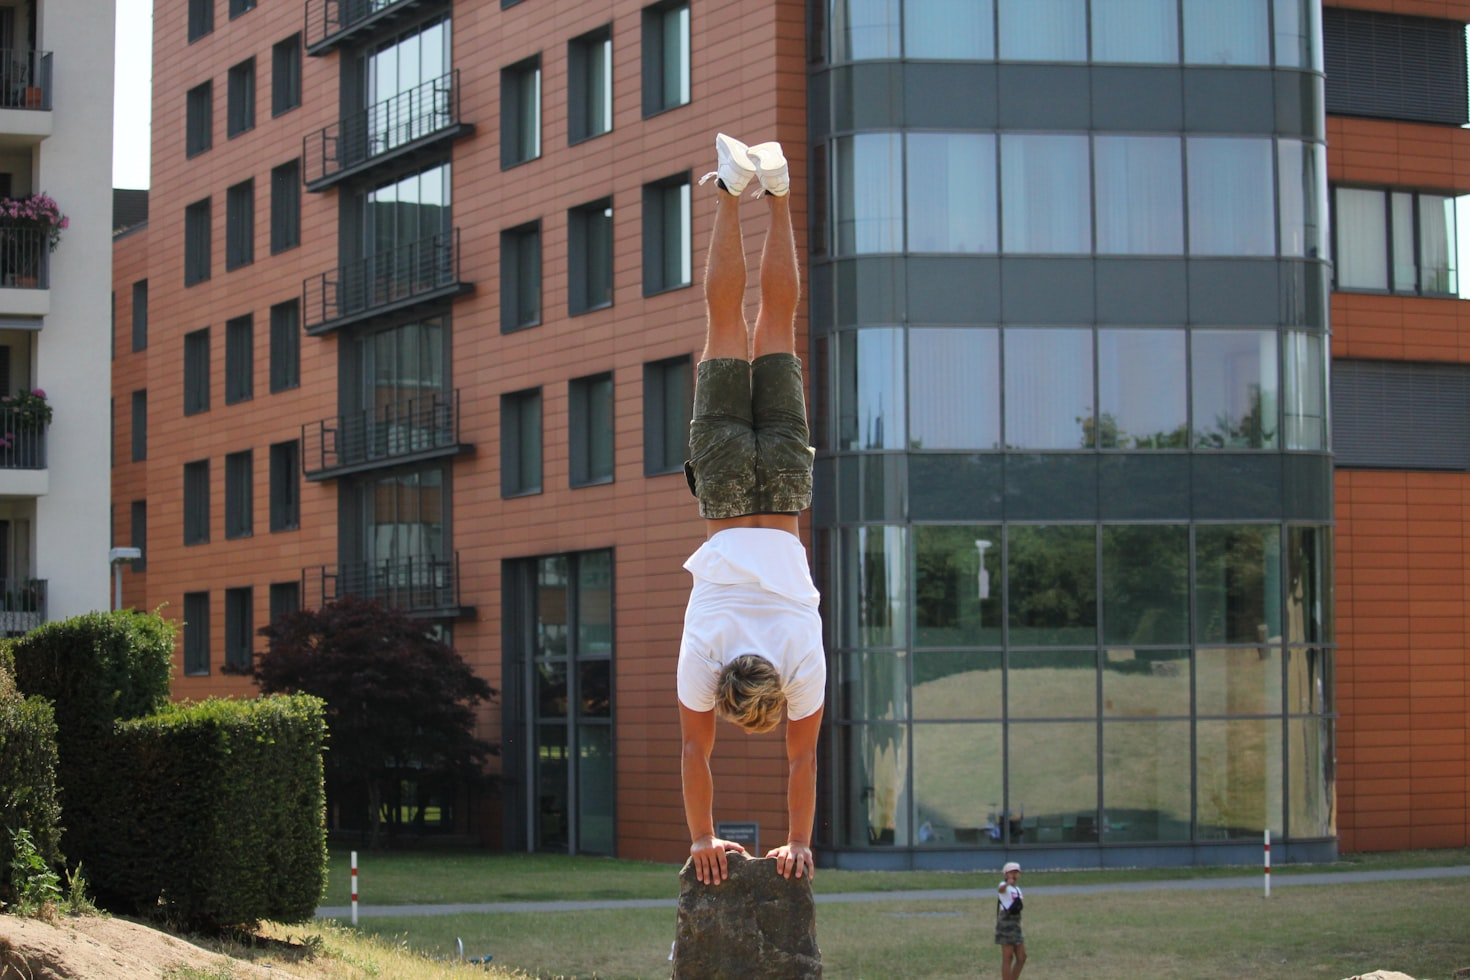

In [4]:
from IPython.display import Image,display

display(Image(base_image_path))

###Bazı görüntü önişleme / yeniden işleme yardımcı programlarını ayarlayalım:

In [5]:
def preprocess_image(image_path):
  #Resimleri uygun dizelere açmak, yeniden boyutlandırmak ve biçimlendirmek için Util işlevi
  img = keras.preprocessing.image.load_img(image_path)
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img

def deprocess_image(x):
  #Numpy dizisini geçerli bir görüntüye dönüştürmek için Util işlevi.
  x = x.reshape((x.shape[1], x.shape[2], 3))
  #Inceptionv3 ön işlemesini geri alma
  x /= 2.0
  x += 0.5
  x *= 255.0
  #Convert to uint8 and clip to the valid range [0, 255]
  x = np.clip(x, 0, 255).astype("uint8")
  return x

#Deep Dream kaybını hesapla

İlk olarak, bir giriş görüntüsü verilen hedef katmanlarımızın aktivasyonunu almak için bir özellik modeli oluşturun.

In [6]:
#Önceden eğitilmiş ImageNet ağırlıklarıyla dolu bir InceptioV3 modeli oluşturun
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

#Her "anahtar" katmanın sembolik çıktılarını alın
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

#Her hedef katman için etkinleştirme değerlerini döndüren bir modeli oluşturun (dict olarak)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  #Kaybı başlat
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    #Sınırda olmayan pikselleri yalnızca kayda dahil ederek kenarlık yapaylıklarında kaçınırız.
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
    loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
  return loss

#Bir oktav için gradyan çıkış döngüsünü ayarlayın.

In [8]:
@tf.function
def gradient_ascent_step(img, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img)
  #Gradyanları Hesapla.
  grads = tape.gradient(loss, img)
  #Gradyanları Normalize et.
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
  img += learning_rate * grads
  return loss, img

def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss ,img = gradient_ascent_step(img, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print("... Loss value at step %d: %.2f" % (i, loss))
  return img

#Farklı oktavlar üzerinde yineleyerek eğitim döngüsünü çalıştırın

In [9]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
  print("Processing octave %d with shape %s" % (i, shape))
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(
      img, iterations=iterations, learning_rate=step, max_loss=max_loss
  )
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (500, 750)
... Loss value at step 0: 1.38
... Loss value at step 1: 1.75
... Loss value at step 2: 2.24
... Loss value at step 3: 2.70
... Loss value at step 4: 3.14
... Loss value at step 5: 3.62
... Loss value at step 6: 4.05
... Loss value at step 7: 4.53
... Loss value at step 8: 5.04
... Loss value at step 9: 5.59
... Loss value at step 10: 6.04
... Loss value at step 11: 6.57
... Loss value at step 12: 7.15
... Loss value at step 13: 7.65
... Loss value at step 14: 8.36
... Loss value at step 15: 8.89
... Loss value at step 16: 9.69
... Loss value at step 17: 10.31
... Loss value at step 18: 11.03
... Loss value at step 19: 11.42
Processing octave 1 with shape (700, 1050)
... Loss value at step 0: 2.08
... Loss value at step 1: 3.49
... Loss value at step 2: 4.49
... Loss value at step 3: 5.36
... Loss value at step 4: 6.36
... Loss value at step 5: 7.11
... Loss value at step 6: 8.11
... Loss value at step 7: 8.92
... Loss value at step 8: 9.88
...

###Sonuçları görselleştirin

In [10]:
display(Image(result_prefix + ".png"))